# i. Perkenalan

Nama : Akbar Fitriawan  
Batch : HCK-14  

### Problems:  
Membuat Model Classification untuk memprediksi default_payment_next_month

### Conceptual Problems:  
-  coeficient regression adalah pembobotan yang di berikan ke setiap fitur dalam model untuk memprediksi probabilitas kejadian kelas tertentu.

- fungsi kernel pada SVM  memproyeksikan data ke dalam ruang dimensi yang lebih tinggi, sehingga dapat memisahkan data yang komplek. Salah satu kernel yang umum digunakan adalah kernel Gaussian atau RBF yang mengukur kesamaan berdasarkan jarak radial antara titik data.

- Untuk memilih nilai K yang optimal dengan menggunakan metode validasi silang (cross-validation).

- sebagai berikut:
  - Accuracy: Merupakan rasio antara jumlah prediksi yang benar dengan total jumlah prediksi. Berguna ketika semua kelas memiliki bobot yang sama.
  -  Precision: Merupakan rasio antara jumlah prediksi positif yang benar dengan total jumlah prediksi positif. Berguna ketika fokus pada mengurangi false positives.
  - Recall: Merupakan rasio antara jumlah prediksi positif yang benar dengan total jumlah kelas positif yang sebenarnya. Berguna ketika fokus pada mengurangi false negatives.
  - F1 Score: Merupakan rata-rata harmonik dari precision dan recall, memberikan keseimbangan antara keduanya. Berguna ketika ingin mempertimbangkan keseimbangan antara false positives dan false negatives.



# ii. Query SQL

In [1]:
# Koneksi dataset bigquery
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "lively-metrics-415004"
client = bigquery.Client(project=project_id)

ModuleNotFoundError: No module named 'google.colab'

# iii. Import Libraries


In [ ]:
# install feature_engine
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
# library dataframe
import pandas as pd
# library olah data numerical
import numpy as np
# library statistik
from scipy import stats
from scipy.stats import uniform

# Data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Pemodelan ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.metrics.pairwise import manhattan_distances

# Evaluasi model
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score , classification_report , confusion_matrix,precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

# Library handling outlier
from feature_engine.outliers import Winsorizer
# library statistik
from scipy.stats import pearsonr, kendalltau, spearmanr
# lib pipelines
from sklearn.pipeline import Pipeline


# Save model
import pickle
import joblib
import json


# iv. Data Loading

In [ ]:
# query data dari
df = client.query('''
SELECT
  limit_balance,
  CAST(sex AS INT) AS sex,
  CAST(education_level AS INT64) AS education_level,
  CAST(marital_status AS INT64) AS marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 28000;

''').to_dataframe()

In [ ]:
df.shape

(2965, 24)

In [ ]:
df.head().T

,0,1,2,3,4
limit_balance,80000.0,200000.0,20000.0,260000.0,150000.0
sex,1,1,2,2,1
education_level,6,4,6,4,4
marital_status,1,1,2,2,2
age,54.0,49.0,22.0,33.0,32.0
pay_0,0.0,0.0,0.0,0.0,0.0
pay_2,0.0,0.0,0.0,0.0,0.0
pay_3,0.0,0.0,0.0,0.0,0.0
pay_4,0.0,0.0,0.0,0.0,-1.0
pay_5,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   Int64  
 2   education_level             2965 non-null   Int64  
 3   marital_status              2965 non-null   Int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

## Save dataframe

In [ ]:
df.to_csv('P1G5_Set_1_akbar_fitriawan.csv', index=False)

## Read Dataframe

In [ ]:
data = pd.read_csv('/content/P1G5_Set_1_akbar_fitriawan.csv')
data.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [ ]:
data.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


# v. Exploratory Data Analysis (EDA)

### Cek data info

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

### Cek Data Terduplikat

In [ ]:
# Cek Duplikat
print(f'Data terduplikat : {data.duplicated().sum()}')

Data terduplikat : 1


In [ ]:
# Drop Duplikat
data.drop_duplicates(inplace=True)

In [ ]:
print(f'Baris: {data.shape[0]}')
print(f'Kolom: {data.shape[1]}')

Baris: 2964
Kolom: 24


### Cek Statistik

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_balance,2964.0,163356.950067,125049.701016,10000.0,50000.00,140000.0,230000.00,800000.0
sex,2964.0,1.607625,0.488362,1.0,1.00,2.0,2.00,2.0
education_level,2964.0,1.849865,0.778159,0.0,1.00,2.0,2.00,6.0
marital_status,2964.0,1.560054,0.522304,0.0,1.00,2.0,2.00,3.0
age,2964.0,35.193657,9.110949,21.0,28.00,34.0,41.00,69.0
pay_0,2964.0,0.004723,1.114434,-2.0,-1.00,0.0,0.00,8.0
pay_2,2964.0,-0.121795,1.180479,-2.0,-1.00,0.0,0.00,7.0
pay_3,2964.0,-0.141026,1.183337,-2.0,-1.00,0.0,0.00,7.0
pay_4,2964.0,-0.184548,1.178049,-2.0,-1.00,0.0,0.00,8.0
pay_5,2964.0,-0.224696,1.158739,-2.0,-1.00,0.0,0.00,7.0


### Cek Outlier

In [ ]:
len(data.columns)

24

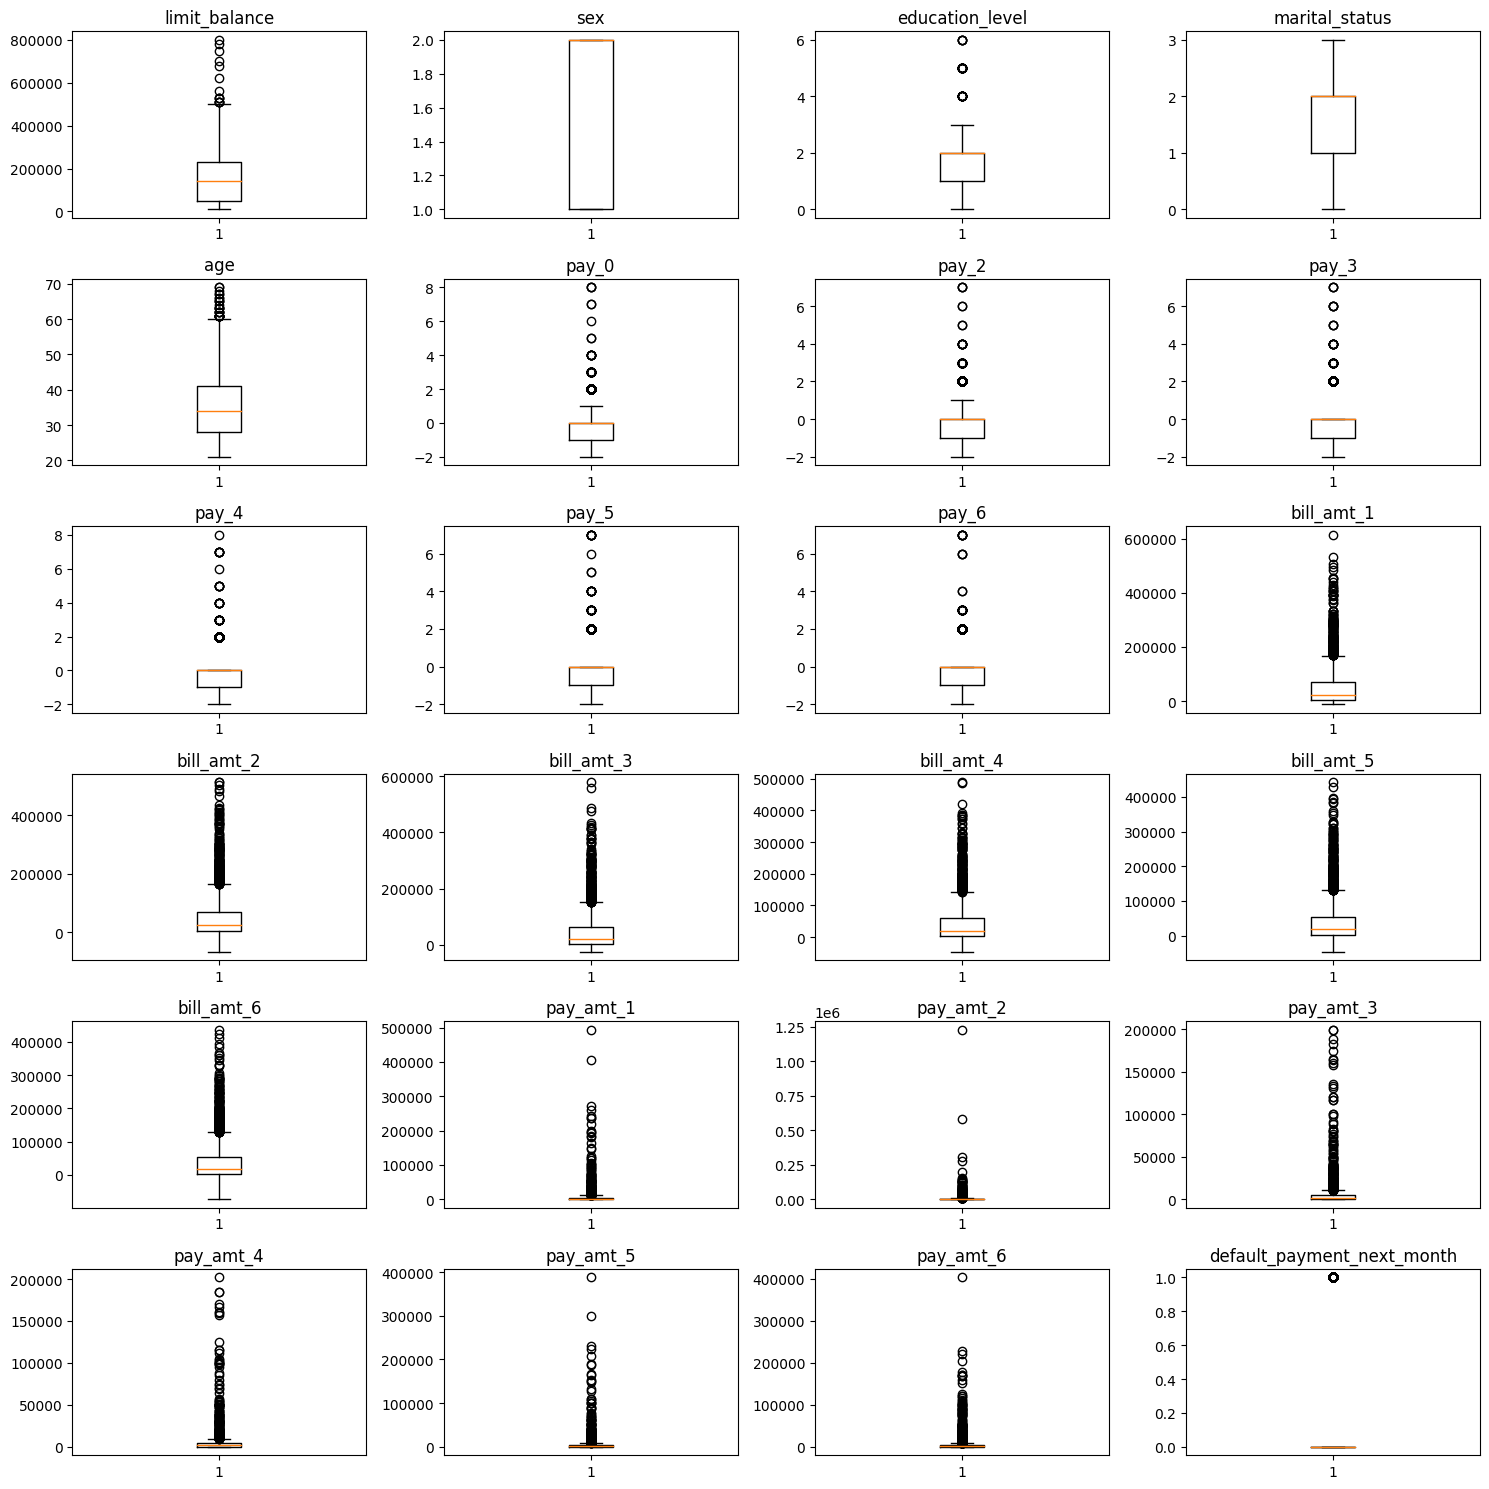

In [ ]:
# list kolom
num_col = data.columns
# plot figure
fig, axes = plt.subplots(6, 4, figsize=(15, 15))
axes = axes.flatten()
# membuat boxplot
for i, column in enumerate(num_col):
    axes[i].boxplot(data[column])
    axes[i].set_title(column)

# hapus plot kosong
for j in range(len(num_col), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# show plot
plt.show()

In [ ]:
# fungsi IQR deteksi outlier
def deteksi_outlier(df, threshold=1.5):
    ''' Fungsi IQR
    Perameters:
    - df (pandas Dataframe)
    - threshold penyesuaian iqr

    penggunaan:
    - deteksi_outlier(df=data)'''
    outliers= {}
    percentages = {}

    for col in df.columns:
        if df[col].dtypes != 'object':
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)

            iqr = (q3 - q1)

            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr

            check_outlier = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outliers[col]= len(check_outlier)

            if len(df[col]) != 0:
                percentage_outlier = len(check_outlier) * 100 / len(df[col])
            else:
                percentage_outlier = 0

            percentages[col] = "{:.2f}%".format(percentage_outlier)

    data = pd.DataFrame({
        'nama_col': list(outliers.keys()),
        'persen_outlier': list(percentages.values())
    })

    return data


In [ ]:
# define outlier dataframe
outlier = deteksi_outlier(df=data)
outlier

,nama_col,persen_outlier
0,limit_balance,0.47%
1,sex,0.00%
2,education_level,1.38%
3,marital_status,0.00%
4,age,0.98%
5,pay_0,10.32%
6,pay_2,14.20%
7,pay_3,13.77%
8,pay_4,12.08%
9,pay_5,10.73%


Untuk sekarang saya abaikan, handling outlier di data preprocessing

### Cek Cardinality

In [ ]:
# cek nilai unik di setiap kolom
data.nunique().to_frame().reset_index().rename(columns={'index':'nama_kolom',0:'Nilai Unik'})

,nama_kolom,Nilai Unik
0,limit_balance,59
1,sex,2
2,education_level,7
3,marital_status,4
4,age,49
5,pay_0,11
6,pay_2,10
7,pay_3,9
8,pay_4,10
9,pay_5,9


In [ ]:
data['default_payment_next_month'].value_counts()

0    2329
1     635
Name: default_payment_next_month, dtype: int64

proprosi 0 dan 1 tidak seimbang

### Cek distribusi data di colom kategorikal

In [ ]:
df.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

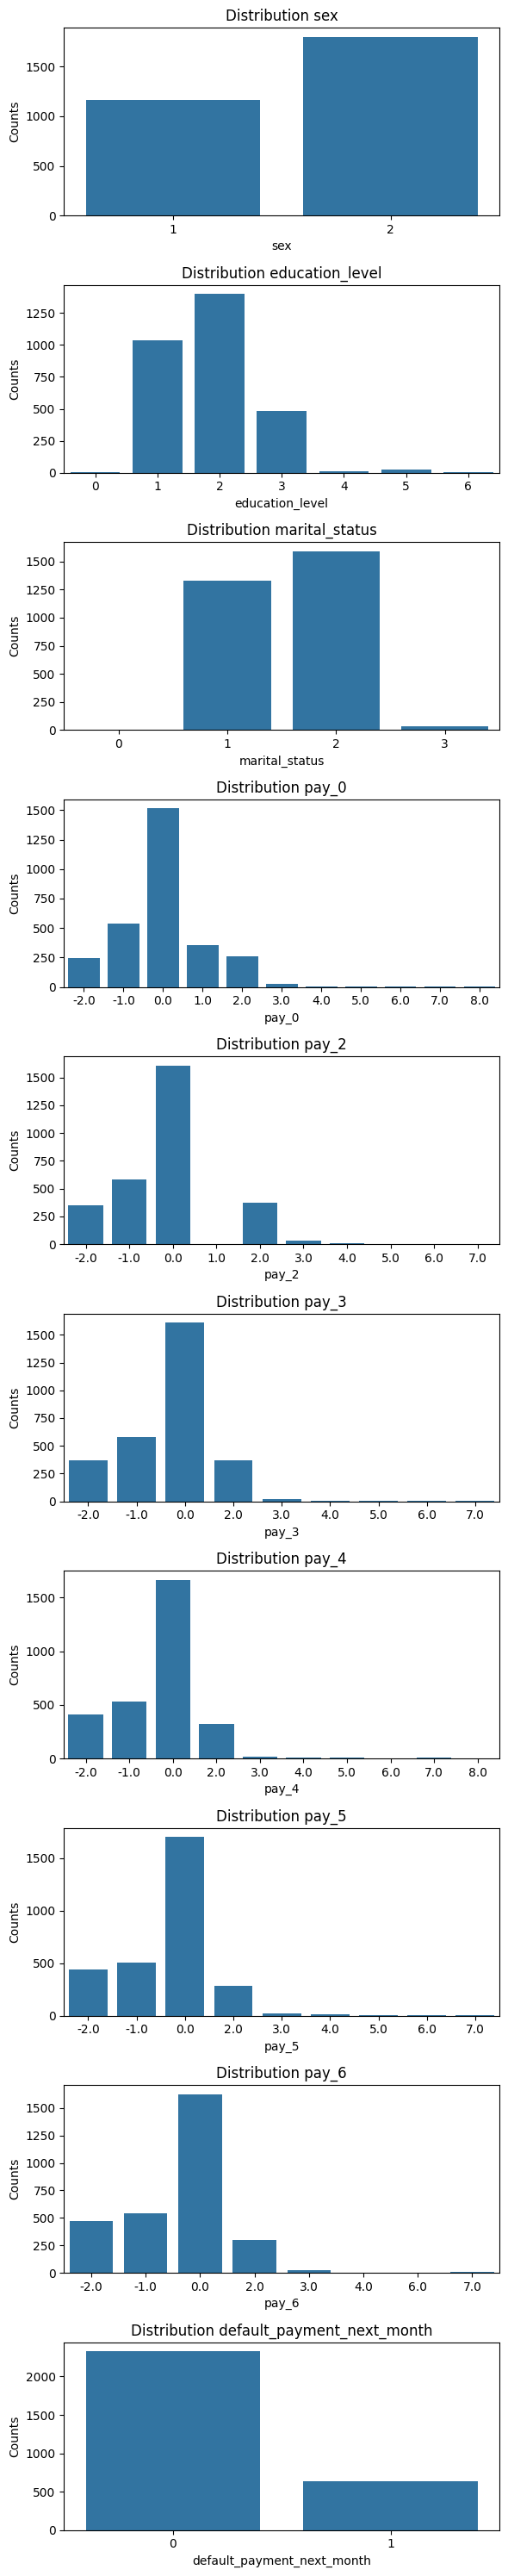

In [ ]:
# kolom kategori yang di plot
cols_category = ['sex','education_level','marital_status','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6','default_payment_next_month']

# Create the subplot grid
fig, axes = plt.subplots(nrows=len(cols_category),ncols=1, figsize=(6, 30))

axes = axes.flatten()

for i, col in enumerate(cols_category):
    sns.countplot(x=col, data=data[cols_category], ax=axes[i])
    axes[i].set_title(f'Distribution {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')



plt.tight_layout()
plt.show()



### Cek distribusi data di colom numerik

In [ ]:
data.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

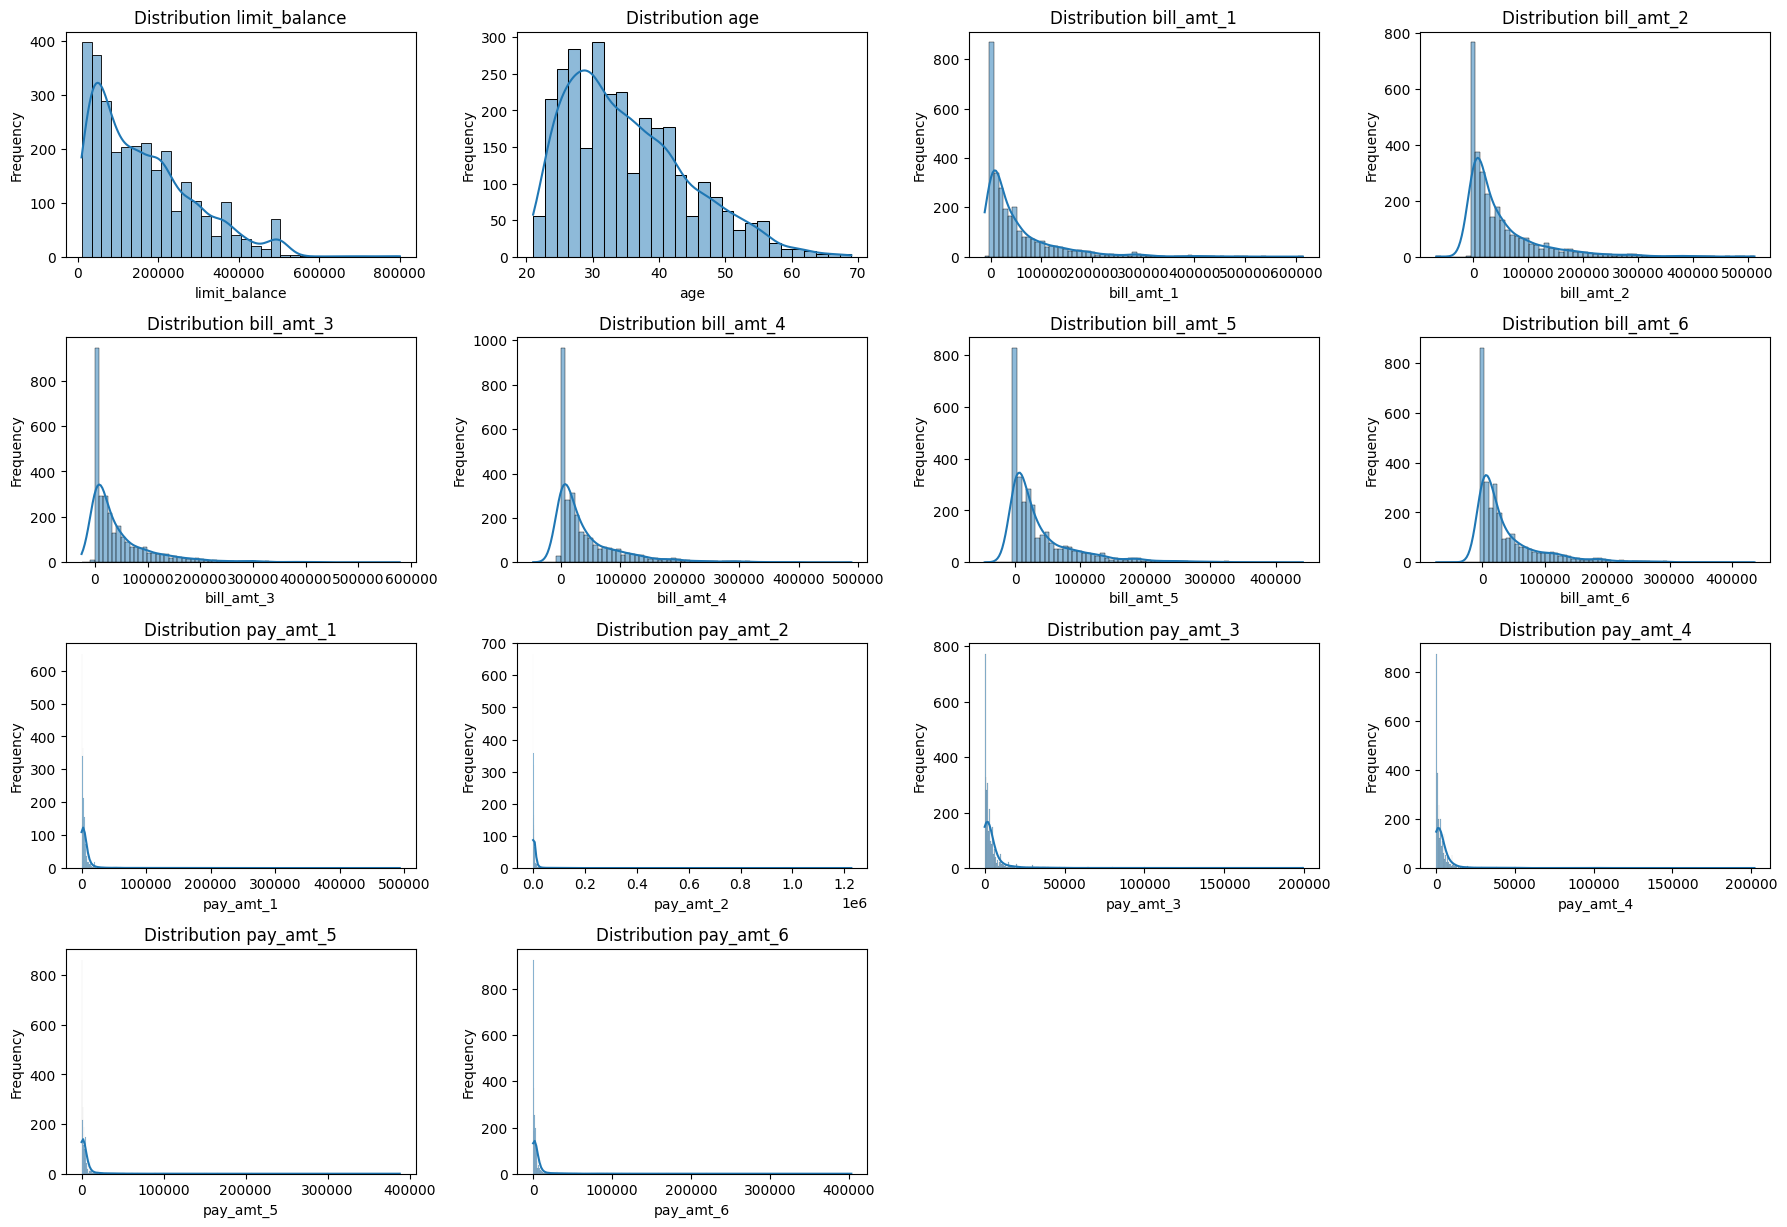

In [ ]:
# Kolom-kolom yang ingin diplot
cols_num = ['limit_balance','age', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6']

# Membuat subplot grid untuk histogram
fig, axes = plt.subplots(5, 4, figsize=(18, 15))

# Flatten axes array
axes = axes.flatten()

# plot di setiap kolom
for i, col in enumerate(cols_num):
    sns.histplot(data[col], ax=axes[i], kde=True)  # membuat histogram dengan kernel density estimate
    axes[i].set_title(f'Distribution {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# hapus figure
for j in range(len(cols_num), len(axes)):
    axes[j].remove()

# display
plt.tight_layout()
plt.show()






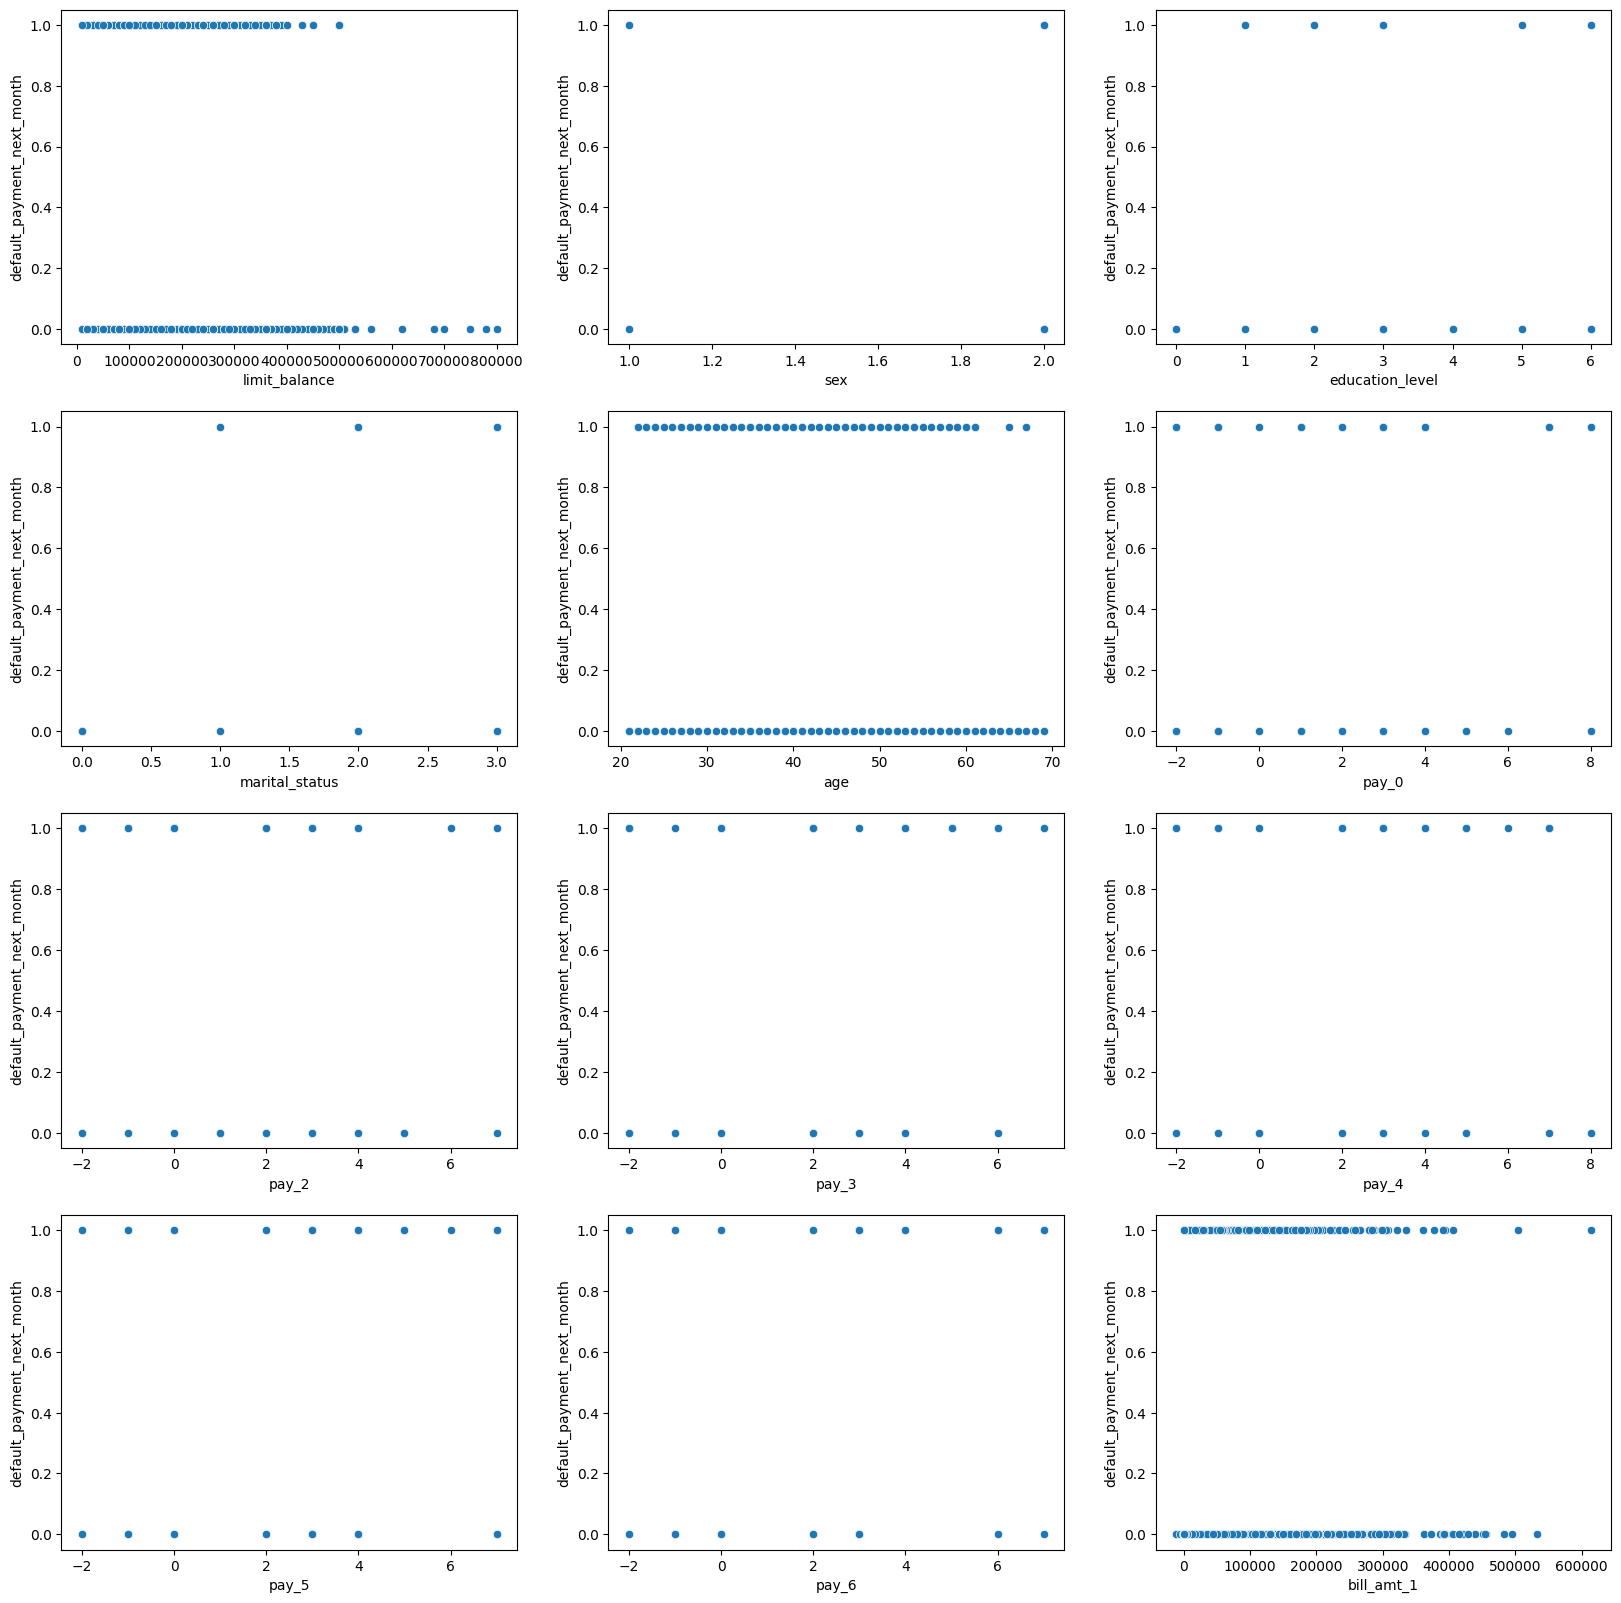

In [ ]:
# Check the relationship between independent variables and dependent variable

fig = plt.figure(figsize=(20, 20))
cols = data.columns.to_list()
num_rows = 4
num_cols = 3

for index in range(1, num_rows*num_cols + 1):
  fig.add_subplot(num_rows, num_cols, index)
  sns.scatterplot(data=data, x=cols[index-1], y='default_payment_next_month')

plt.show()

In [ ]:
data

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


# vi. Feature Engineering

### Split Data

In [ ]:
# Definisikan data fitur dan prediksi
X = data.drop('default_payment_next_month', axis=1)
y = data['default_payment_next_month']

In [ ]:
X.head(3)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0


In [ ]:
y.head(3)

0    1
1    0
2    1
Name: default_payment_next_month, dtype: int64

In [ ]:
# Spilt data training dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

In [ ]:
X_train.head(3)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1351,200000.0,2,1,2,30.0,0.0,0.0,2.0,2.0,0.0,...,209286.0,188243.0,188668.0,190192.0,13600.0,12200.0,0.0,7000.0,7000.0,7300.0
598,140000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,103265.0,117188.0,113368.0,119194.0,12682.0,13265.0,17188.0,10000.0,15000.0,0.0
1348,260000.0,2,1,1,36.0,0.0,0.0,2.0,0.0,0.0,...,89200.0,79702.0,79025.0,79997.0,10000.0,0.0,3012.0,3000.0,3000.0,4000.0


In [ ]:
y_train.head(3)

1351    0
598     0
1348    0
Name: default_payment_next_month, dtype: int64

In [ ]:
X_test.head(3)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1229,70000.0,2,3,1,42.0,0.0,0.0,0.0,0.0,0.0,...,11179.0,8688.0,8295.0,10147.0,3000.0,2000.0,295.0,1000.0,2000.0,1000.0
2659,300000.0,1,2,1,39.0,-1.0,-1.0,-2.0,-2.0,-2.0,...,1049.0,-25.0,-25.0,-25.0,598.0,1057.0,0.0,0.0,0.0,0.0
1969,240000.0,2,2,1,38.0,1.0,2.0,-1.0,2.0,2.0,...,189.0,189.0,1648.0,1459.0,899.0,198.0,0.0,1459.0,0.0,1250.0


In [ ]:
y_test.head(3)

1229    0
2659    0
1969    1
Name: default_payment_next_month, dtype: int64

### Cek missing Value

In [ ]:
X_train.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [ ]:
X_test.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [ ]:
print(f'missing value y_train : {y_train.isnull().sum()}')

missing value y_train : 0


In [ ]:
print(f'missing value y_test : {y_test.isnull().sum()}')

missing value y_test : 0


In [ ]:
# cek ukuran
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print()
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (2074, 23)
y_train : (2074,)

X_test : (890, 23)
y_test : (890,)


In [ ]:
# buat list category dan list numeric
cols_cat = ['sex','education_level','marital_status','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
cols_num = [x for x in X_train.columns if x not in cols_cat]

# cols_cat = ['sex','education_level','marital_status']
# cols_num = [x for x in X_train.columns if x not in cols_cat]

print(cols_cat)
print(cols_num)

['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


### Handling Outlier

In [ ]:
# pake cols_num

# buat data dan kolom untuk normal distribusi
normal_data_num = []
cols_normal = []

# buat data dan kolom untuk Skewed
skew_data_num = []
cols_skew = []

# cek di setiap kolom
for col in cols_num:
  skewness = X_train[col].skew()

  if skewness <= 0.5 and skewness >= -0.5:
    cols_normal.append(col)
    normal_data_num.append([col,skewness])
  elif skewness < -0.5 or skewness > 0.5:
    cols_skew.append(col)
    skew_data_num.append([col, skewness])

In [ ]:
# Tampilkan data skew
pd.DataFrame(data=skew_data_num, columns=['kolom_ditribusi_skewed', 'skewness'])

,kolom_ditribusi_skewed,skewness
0,limit_balance,1.005721
1,age,0.748477
2,bill_amt_1,2.586702
3,bill_amt_2,2.496346
4,bill_amt_3,2.655950
5,bill_amt_4,2.445700
6,bill_amt_5,2.408562
7,bill_amt_6,2.444229
8,pay_amt_1,12.901019
9,pay_amt_2,26.866983


In [ ]:
# Tampilkan data normal
pd.DataFrame(data=normal_data_num, columns=['kolom_ditribusi_normal', 'skewness'])

,kolom_ditribusi_normal,skewness


Data kebanyakan skew sehingga untuk handling menggunakan iqr

In [ ]:
cols_skew

['limit_balance',
 'age',
 'bill_amt_1',
 'bill_amt_2',
 'bill_amt_3',
 'bill_amt_4',
 'bill_amt_5',
 'bill_amt_6',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6']

In [ ]:
skew_data_num

[['limit_balance', 1.0057211979978586],
 ['age', 0.748477300387431],
 ['bill_amt_1', 2.5867018041800662],
 ['bill_amt_2', 2.4963464404478106],
 ['bill_amt_3', 2.655950278597777],
 ['bill_amt_4', 2.445700415798871],
 ['bill_amt_5', 2.4085619697882525],
 ['bill_amt_6', 2.444229057027229],
 ['pay_amt_1', 12.901019137244997],
 ['pay_amt_2', 26.86698310851015],
 ['pay_amt_3', 8.046176600702896],
 ['pay_amt_4', 9.308391930433476],
 ['pay_amt_5', 12.791715555895454],
 ['pay_amt_6', 10.386318911293339]]

In [ ]:
# mengguanakan censoring iqr
winsorizer_skewed = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=cols_skew,
                            missing_values='ignore')
# Fit & Transforming X_train
X_train_capped = winsorizer_skewed.fit_transform(X_train)

# Transforming X_test
X_test_capped = winsorizer_skewed.transform(X_test)



#### Sebelum handling outlier

In [ ]:
sebelum_handling_train = deteksi_outlier(X_train)
sebelum_handling_train

,nama_col,persen_outlier
0,limit_balance,0.39%
1,sex,0.00%
2,education_level,1.40%
3,marital_status,0.00%
4,age,0.92%
5,pay_0,10.80%
6,pay_2,14.42%
7,pay_3,14.08%
8,pay_4,12.25%
9,pay_5,10.75%


#### Sesudah handling outlier

In [ ]:
sesudah_handling_train = deteksi_outlier(X_train_capped)
sesudah_handling_train

,nama_col,persen_outlier
0,limit_balance,0.00%
1,sex,0.00%
2,education_level,1.40%
3,marital_status,0.00%
4,age,0.00%
5,pay_0,10.80%
6,pay_2,14.42%
7,pay_3,14.08%
8,pay_4,12.25%
9,pay_5,10.75%


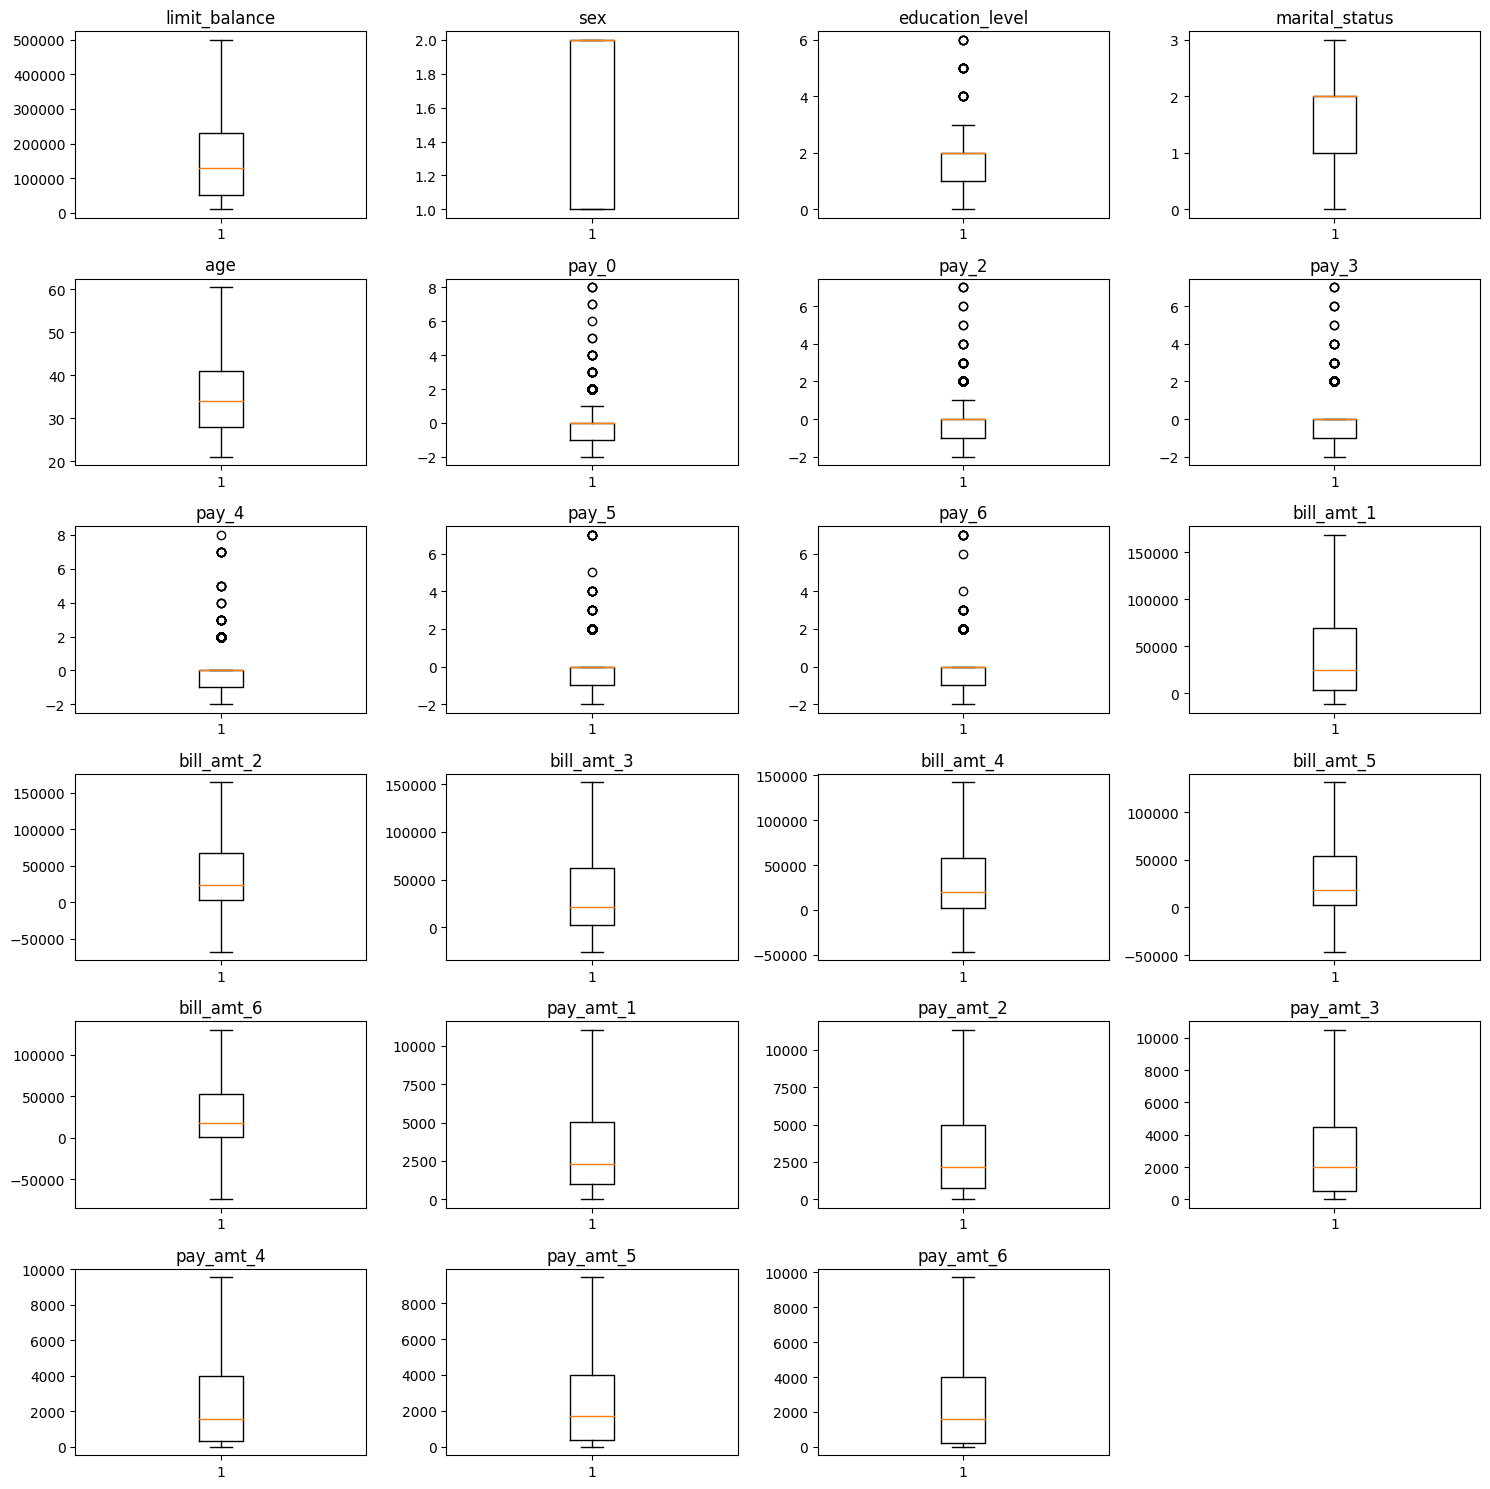

In [ ]:
# list kolom
num_col = X_train_capped.columns
# plot figure
fig, axes = plt.subplots(6, 4, figsize=(15, 15))
axes = axes.flatten()
# membuat boxplot
for i, column in enumerate(num_col):
    axes[i].boxplot(X_train_capped[column])
    axes[i].set_title(column)

# hapus plot kosong
for j in range(len(num_col), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# show plot
plt.show()

Catatan:  
Hanya mengurang dampak outlier dan bukan di hapus, karena data merupakan tipikal transaksi

In [ ]:
print(f'X_train : {X_train_capped.shape}')
print(f'y_train : {y_train.shape}')
print()
print(f'X_test : {X_test_capped.shape}')
print(f'y_test : {y_test.shape}')

X_train : (2074, 23)
y_train : (2074,)

X_test : (890, 23)
y_test : (890,)


### Split Data Numerikal dan Kategorikal

In [ ]:
# buat lsit kolom numerik dan kategorikal
cat_columns = ['sex','education_level','marital_status','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
num_columns = [x for x in X_train.columns if x not in cols_cat]



print(cat_columns)
print(num_columns)

['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


In [ ]:
X_train_num = X_train_capped[num_columns]
X_train_cat = X_train_capped[cat_columns]

X_test_num = X_test_capped[num_columns]
X_test_cat = X_test_capped[cat_columns]

### Feature Selection

#### Kategorikal fitur

In [ ]:
# Checking korelasi di kolom kategori
p_values = []
interpretation = []
cols = []
corr = []

# mecari kolom korelasi di setiap kolom menggunakan kendalltau
for col in X_train_cat.columns:
  corr_coef, p_value = kendalltau(X_train_cat[col], y_train)

  # memasukan ke list
  p_values.append(p_value)
  cols.append(col)
  corr.append(corr_coef)

  # aturan kondisi
  if p_value < 0.05:
    interpretation.append('Significant Correlation')
  else:
    interpretation.append('No Significant Correlation')

# membuat dataframe hasil dari korelasi
dfCorr = pd.DataFrame({'Column Name':cols,
              'Correlation Coefficient' : corr,
              'P-value':p_values,
              'Interpretation': interpretation})

dfCorr

,Column Name,Correlation Coefficient,P-value,Interpretation
0,sex,-0.012318,5.749114e-01,No Significant Correlation
1,education_level,0.050606,1.517566e-02,Significant Correlation
2,marital_status,-0.038056,8.116506e-02,No Significant Correlation
3,pay_0,0.296883,4.906301e-49,Significant Correlation
4,pay_2,0.218296,1.281876e-26,Significant Correlation
5,pay_3,0.202750,3.702240e-23,Significant Correlation
6,pay_4,0.186070,1.144750e-19,Significant Correlation
7,pay_5,0.191906,1.019930e-20,Significant Correlation
8,pay_6,0.189326,2.550215e-20,Significant Correlation


In [ ]:
# extract data
corrCat = (dfCorr[dfCorr['Interpretation']=='Significant Correlation'])
list_corrCat = list(corrCat['Column Name'].values)

corrCat

,Column Name,Correlation Coefficient,P-value,Interpretation
1,education_level,0.050606,1.517566e-02,Significant Correlation
3,pay_0,0.296883,4.906301e-49,Significant Correlation
4,pay_2,0.218296,1.281876e-26,Significant Correlation
5,pay_3,0.202750,3.702240e-23,Significant Correlation
6,pay_4,0.186070,1.144750e-19,Significant Correlation
7,pay_5,0.191906,1.019930e-20,Significant Correlation
8,pay_6,0.189326,2.550215e-20,Significant Correlation


<Axes: >

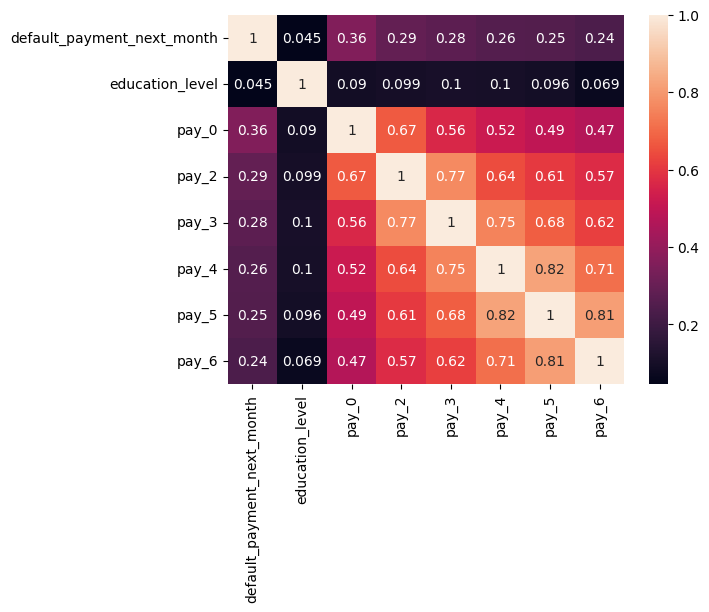

In [ ]:
sns.heatmap(data[['default_payment_next_month']+list_corrCat].corr(),annot=True)

Kolom education_level memenuhi korelasi sedangkan jenis kelamin dan status pernikahan tidak ada korelasi

#### Numerikal fitur

In [ ]:
# Checking korelasi di kolom numerik
p_values = []
interpretation = []
cols = []
corr = []

# mencari korelasi di setiap kolom
for col in X_train_num.columns:
  if abs(X_train_num[col].skew()) < 0.5:                    #For Normally Distributed Columns
    corr_coef, p_value = pearsonr(X_train_num[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    if p_value < 0.05:
      interpretation.append('Significant Correlation')
    else :
      interpretation.append('No Significant Correlation')
  else:                                                     #For Non Normally Distributed Columns
    corr_coef, p_value = spearmanr(X_train_num[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    if p_value < 0.05:
      interpretation.append('Significant Correlation')
    else :
      interpretation.append('No Significant Correlation')

dfCorrNum = pd.DataFrame({'Column Name':cols,
              'Correlation Coefficient' : corr,
              'P-value':p_values,
              'Interpretation': interpretation })

dfCorrNum

,Column Name,Correlation Coefficient,P-value,Interpretation
0,limit_balance,-0.175284,8.972223e-16,Significant Correlation
1,age,0.007979,7.164946e-01,No Significant Correlation
2,bill_amt_1,-0.007868,7.202524e-01,No Significant Correlation
3,bill_amt_2,0.004565,8.353923e-01,No Significant Correlation
4,bill_amt_3,0.011417,6.033076e-01,No Significant Correlation
5,bill_amt_4,0.019308,3.794686e-01,No Significant Correlation
6,bill_amt_5,0.022921,2.967763e-01,No Significant Correlation
7,bill_amt_6,0.027233,2.150847e-01,No Significant Correlation
8,pay_amt_1,-0.144883,3.375570e-11,Significant Correlation
9,pay_amt_2,-0.142216,7.723906e-11,Significant Correlation


In [ ]:
corrNum = dfCorrNum[dfCorrNum['Interpretation'] == 'Significant Correlation']
corrNum

,Column Name,Correlation Coefficient,P-value,Interpretation
0,limit_balance,-0.175284,8.972223e-16,Significant Correlation
8,pay_amt_1,-0.144883,3.375570e-11,Significant Correlation
9,pay_amt_2,-0.142216,7.723906e-11,Significant Correlation
10,pay_amt_3,-0.110153,4.936556e-07,Significant Correlation
11,pay_amt_4,-0.113687,2.089788e-07,Significant Correlation
12,pay_amt_5,-0.079555,2.872024e-04,Significant Correlation
13,pay_amt_6,-0.128784,3.957836e-09,Significant Correlation


In [ ]:
# extract data
list_corrNum = list(corrNum['Column Name'].values)
list_corrNum

['limit_balance',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6']

<Axes: >

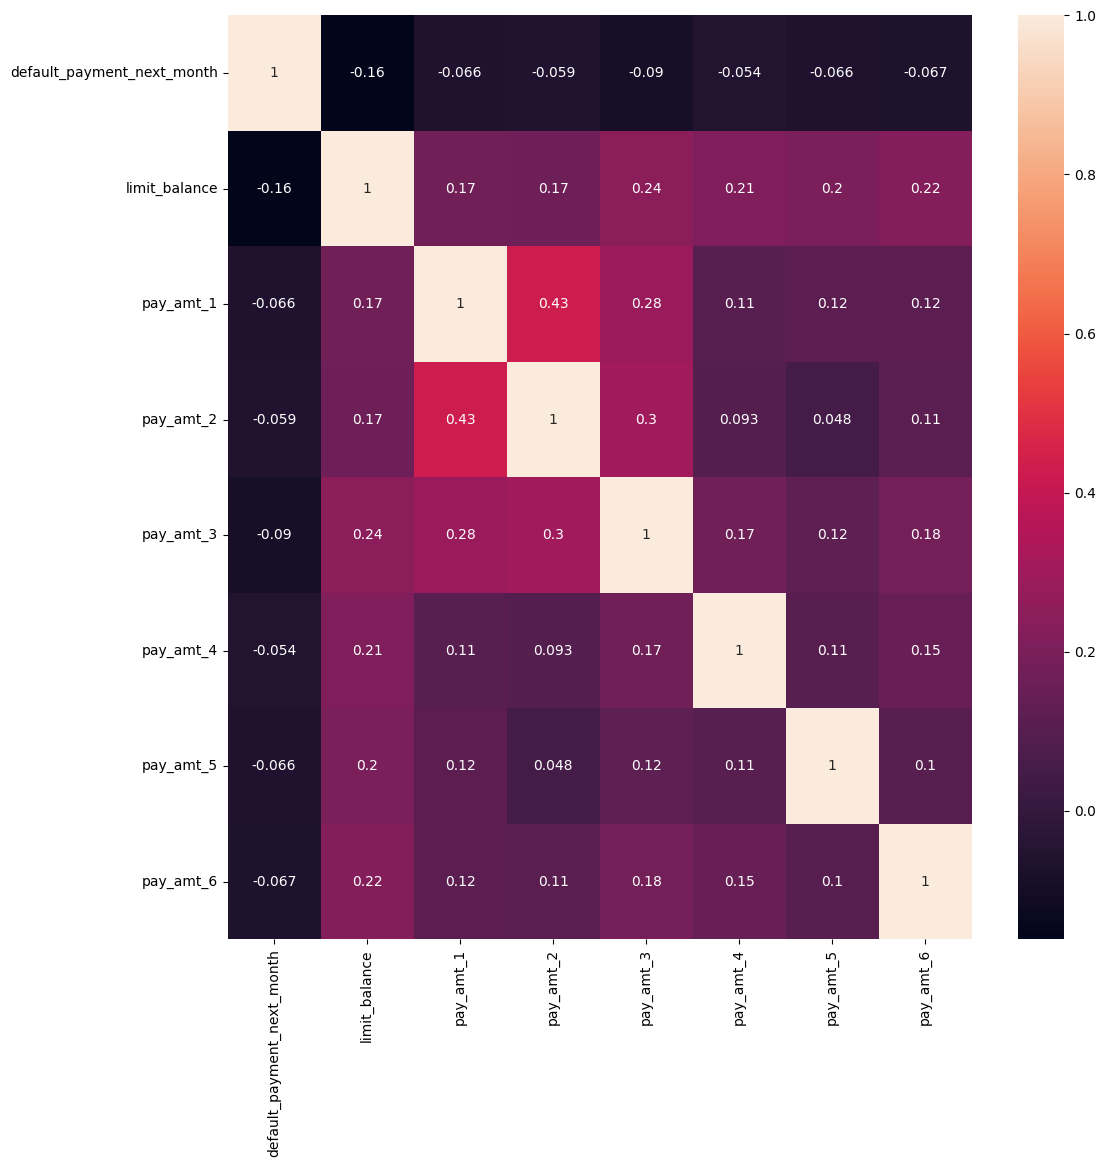

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data[['default_payment_next_month']+list_corrNum].corr(),annot=True)

#### Membuat Variabel Baru untuk Menyimpan Hanya Fitur yang Berkorelasi

In [ ]:
# Membuat dataframe Categorical & Numerical
selected_cat_col = list_corrCat
selected_num_col = list_corrNum


X_train_cat = X_train_cat[selected_cat_col]
X_train_num = X_train_num[selected_num_col]

X_test_cat = X_test_cat[selected_cat_col]
X_test_num = X_test_num[selected_num_col]

In [ ]:
# Checking categorical
X_train_cat

,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1351,1,0.0,0.0,2.0,2.0,0.0,0.0
598,2,0.0,0.0,0.0,0.0,0.0,0.0
1348,1,0.0,0.0,2.0,0.0,0.0,0.0
1725,1,0.0,0.0,0.0,0.0,2.0,-1.0
1985,1,3.0,2.0,2.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...
658,2,0.0,0.0,0.0,0.0,0.0,0.0
2451,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2490,1,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0
1576,1,-1.0,-1.0,-1.0,0.0,0.0,-2.0


In [ ]:
# Checking the numerical data
X_train_num

,limit_balance,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1351,200000.0,11042.5,11330.0,0.0,7000.0,7000.000,7300.0
598,140000.0,11042.5,11330.0,10495.0,9550.0,9437.875,0.0
1348,260000.0,10000.0,0.0,3012.0,3000.0,3000.000,4000.0
1725,170000.0,10000.0,1400.0,2500.0,0.0,3605.000,0.0
1985,80000.0,1200.0,300.0,1100.0,700.0,500.000,0.0
...,...,...,...,...,...,...,...
658,300000.0,11042.5,11330.0,10495.0,9550.0,8814.000,9463.0
2451,150000.0,3146.0,2659.0,2472.0,4116.0,4703.000,4708.0
2490,120000.0,2647.0,10363.0,3600.0,0.0,0.000,0.0
1576,300000.0,668.0,9800.0,0.0,0.0,0.000,0.0


#### Scaling Data Numerik

In [ ]:
#Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

#Fit_transform untuk X_train, transform untuk X_test
X_train_num_scaled = scaler.fit_transform(X_train_num) ## hanya fit X_train
X_test_num_scaled = scaler.transform(X_test_num)

print(X_train_num_scaled)
print('')


#Fit_transform untuk X_train, transform untuk X_test
X_train_cat_scaled = scaler.fit_transform(X_train_cat) ## hanya fit X_train
X_test_cat_scaled = scaler.transform(X_test_cat)

print(X_train_cat_scaled)

[[0.3877551  1.         1.         ... 0.73298429 0.74169238 0.75144434]
 [0.26530612 1.         1.         ... 1.         1.         0.        ]
 [0.51020408 0.90559203 0.         ... 0.31413613 0.31786816 0.41175032]
 ...
 [0.2244898  0.23971021 0.91465137 ... 0.         0.         0.        ]
 [0.59183673 0.06049355 0.86496028 ... 0.         0.         0.        ]
 [0.16326531 0.         0.         ... 0.         0.         0.        ]]

[[0.16666667 0.2        0.22222222 ... 0.4        0.22222222 0.22222222]
 [0.33333333 0.2        0.22222222 ... 0.2        0.22222222 0.22222222]
 [0.16666667 0.2        0.22222222 ... 0.2        0.22222222 0.22222222]
 ...
 [0.16666667 0.1        0.11111111 ... 0.1        0.11111111 0.        ]
 [0.16666667 0.1        0.11111111 ... 0.2        0.22222222 0.        ]
 [0.33333333 0.1        0.11111111 ... 0.         0.         0.        ]]


#### Encoding

Alasan tidak Encoding data kategori kerena sudah menjadi tipe data int dan bersifat numerik

#### Concatenate (Menggabungkan kembali Numerik dan Kategorikal)

In [ ]:
# Concate
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat], axis = 1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat], axis = 1)

# Transform into dataframe
X_train_final = pd.DataFrame(X_train_final)
X_test_final = pd.DataFrame(X_test_final)

In [ ]:
X_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.387755,1.000000,1.000000,0.000000,0.732984,0.741692,0.751444,1.0,0.0,0.0,2.0,2.0,0.0,0.0
1,0.265306,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.510204,0.905592,0.000000,0.286994,0.314136,0.317868,0.411750,1.0,0.0,0.0,2.0,0.0,0.0,0.0
3,0.326531,0.905592,0.123566,0.238209,0.000000,0.381972,0.000000,1.0,0.0,0.0,0.0,0.0,2.0,-1.0
4,0.142857,0.108671,0.026478,0.104812,0.073298,0.052978,0.000000,1.0,3.0,2.0,2.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,0.591837,1.000000,1.000000,1.000000,1.000000,0.933897,0.974098,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2070,0.285714,0.284899,0.234687,0.235541,0.430995,0.498311,0.484630,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2071,0.224490,0.239710,0.914651,0.343020,0.000000,0.000000,0.000000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0
2072,0.591837,0.060494,0.864960,0.000000,0.000000,0.000000,0.000000,1.0,-1.0,-1.0,-1.0,0.0,0.0,-2.0


In [ ]:
X_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.122449,0.271678,0.176523,0.028109,0.104712,0.211912,0.102938,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.591837,0.054154,0.093292,0.000000,0.000000,0.000000,0.000000,2.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
2,0.469388,0.081413,0.017476,0.000000,0.152775,0.000000,0.128672,2.0,1.0,2.0,-1.0,2.0,2.0,2.0
3,0.020408,0.249038,0.000000,0.117294,0.186073,0.000000,0.500174,2.0,0.0,0.0,2.0,0.0,0.0,2.0
4,0.795918,0.499796,1.000000,0.143116,0.212147,0.107545,1.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0.285714,0.000000,0.791615,0.574273,0.000000,0.154802,1.000000,1.0,-1.0,2.0,-1.0,-1.0,0.0,-1.0
886,0.020408,0.117818,0.984201,0.000000,0.062827,0.860363,0.154406,2.0,-1.0,-1.0,-1.0,2.0,0.0,0.0
887,0.081633,0.309260,0.301942,0.194759,1.000000,0.027231,0.000000,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
888,0.020408,0.144623,0.130538,0.152454,0.041885,0.000000,0.030675,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train

1351    0
598     0
1348    0
1725    0
1985    1
       ..
658     1
2451    0
2490    0
1576    0
2886    0
Name: default_payment_next_month, Length: 2074, dtype: int64

In [ ]:
y_test

1229    0
2659    0
1969    1
1405    1
615     0
       ..
1570    0
1613    0
2457    0
528     0
2199    0
Name: default_payment_next_month, Length: 890, dtype: int64

# vii. Model Definition

### Model Manual parameter

In [ ]:
# Define Model
logReg = LogisticRegression(penalty='l2',class_weight='balanced',solver='liblinear',C=0.5,random_state=22)
model_svc = SVC(kernel='linear',random_state=22)
knn = KNeighborsClassifier(n_neighbors=3,p=2)

# viii. Model Training

In [ ]:
logReg.fit(X_train_final,y_train)


LogisticRegression(C=0.5, class_weight='balanced', random_state=22,
                   solver='liblinear')

In [ ]:
model_svc.fit(X_train_final,y_train)


SVC(kernel='linear', random_state=22)

In [ ]:
knn.fit(X_train_final,y_train)


KNeighborsClassifier(n_neighbors=3)

# ix. Model Evaluation

In [ ]:
# Save Classification Report into a Dictionary

all_reports = {}
def performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, name):
  score_reports = {
      'train - precision' : precision_score(y_train, y_train_pred),
      'train - recall' : recall_score(y_train, y_train_pred),
      'train - accuracy' : accuracy_score(y_train, y_train_pred),
      'train - f1_score' : f1_score(y_train, y_train_pred),
      'test - precision' : precision_score(y_test, y_test_pred),
      'test - recall' : recall_score(y_test, y_test_pred),
      'test - accuracy_score' : accuracy_score(y_test, y_test_pred),
      'test - f1_score' : f1_score(y_test, y_test_pred),
  }
  all_reports[name] = score_reports
  return all_reports

### Evaluasi model Logistic Regression

Classification Report for Training Set:
               precision    recall  f1-score   support

           0       0.89      0.70      0.78      1641
           1       0.37      0.67      0.48       433

    accuracy                           0.70      2074
   macro avg       0.63      0.69      0.63      2074
weighted avg       0.78      0.70      0.72      2074



<Figure size 700x700 with 0 Axes>

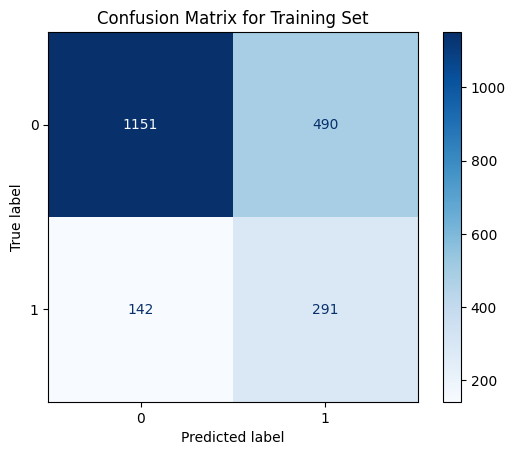

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.87      0.72      0.79       688
           1       0.40      0.63      0.49       202

    accuracy                           0.70       890
   macro avg       0.63      0.68      0.64       890
weighted avg       0.76      0.70      0.72       890



<Figure size 700x700 with 0 Axes>

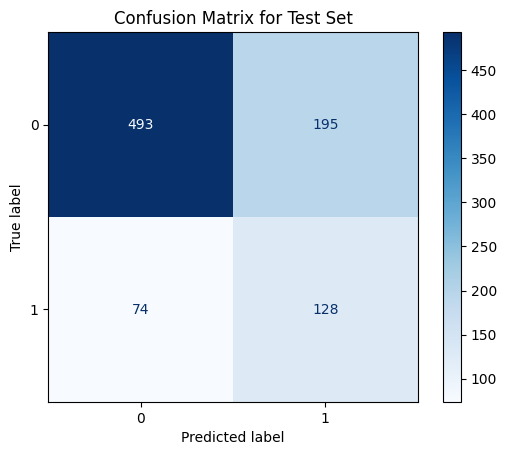

,Manual LogReg
test - accuracy_score,0.697753
test - f1_score,0.487619
test - precision,0.396285
test - recall,0.633663
train - accuracy,0.695275
train - f1_score,0.479407
train - precision,0.372599
train - recall,0.672055


In [ ]:
# Calculate predictions for training and test sets
y_train_pred = logReg.predict(X_train_final)
y_test_pred = logReg.predict(X_test_final)

# Generate classification reports for training and test sets
train_classification_report = classification_report(y_train, y_train_pred)
test_classification_report = classification_report(y_test, y_test_pred)

train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

train_conf_matrix_display = ConfusionMatrixDisplay(train_conf_matrix)
test_conf_matrix_display = ConfusionMatrixDisplay(test_conf_matrix)

print("Classification Report for Training Set:\n", train_classification_report)

# Display confusion matrix and classification report for training set
plt.figure(figsize=(7, 7))
train_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Training Set')
plt.show()


print("Classification Report for Test Set:\n", test_classification_report)

# Display confusion matrix and classification report for test set
plt.figure(figsize=(7, 7))
test_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()
print('')


# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Manual LogReg')
pd.DataFrame(all_reports)



### Evaluasi model KNN

Classification Report for Training Set:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      1641
           1       0.78      0.60      0.68       433

    accuracy                           0.88      2074
   macro avg       0.84      0.78      0.80      2074
weighted avg       0.87      0.88      0.87      2074



<Figure size 700x700 with 0 Axes>

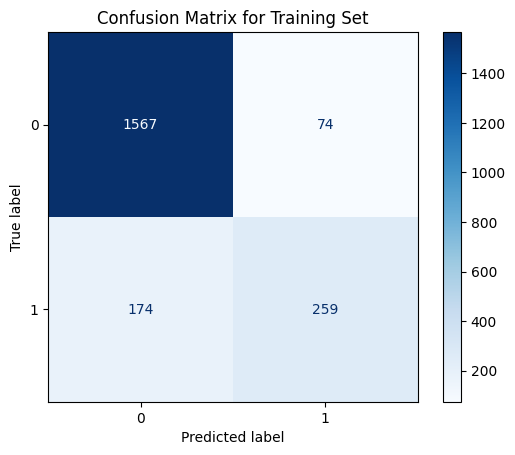

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.83      0.92      0.88       688
           1       0.59      0.37      0.45       202

    accuracy                           0.80       890
   macro avg       0.71      0.65      0.67       890
weighted avg       0.78      0.80      0.78       890



<Figure size 700x700 with 0 Axes>

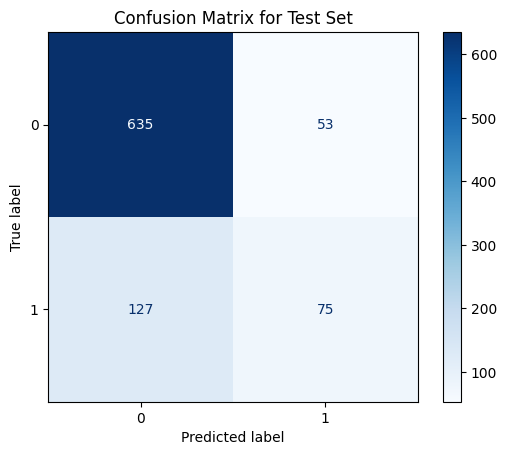

,Manual LogReg,Manual KNN
train - precision,0.372599,0.777778
train - recall,0.672055,0.598152
train - accuracy,0.695275,0.880424
train - f1_score,0.479407,0.676240
test - precision,0.396285,0.585938
test - recall,0.633663,0.371287
test - accuracy_score,0.697753,0.797753
test - f1_score,0.487619,0.454545


In [ ]:
# Calculate predictions for training and test sets
y_train_pred = knn.predict(X_train_final)
y_test_pred = knn.predict(X_test_final)

# Generate classification reports for training and test sets
train_classification_report = classification_report(y_train, y_train_pred)
test_classification_report = classification_report(y_test, y_test_pred)

train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

train_conf_matrix_display = ConfusionMatrixDisplay(train_conf_matrix)
test_conf_matrix_display = ConfusionMatrixDisplay(test_conf_matrix)

print("Classification Report for Training Set:\n", train_classification_report)

# Display confusion matrix and classification report for training set
plt.figure(figsize=(7, 7))
train_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Training Set')
plt.show()


print("Classification Report for Test Set:\n", test_classification_report)

# Display confusion matrix and classification report for test set
plt.figure(figsize=(7, 7))
test_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()

print('')

# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Manual KNN')
pd.DataFrame(all_reports)




### Evaluasi model SVC

Classification Report for Training Set:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      1641
           1       0.71      0.27      0.39       433

    accuracy                           0.82      2074
   macro avg       0.77      0.62      0.65      2074
weighted avg       0.81      0.82      0.79      2074



<Figure size 700x700 with 0 Axes>

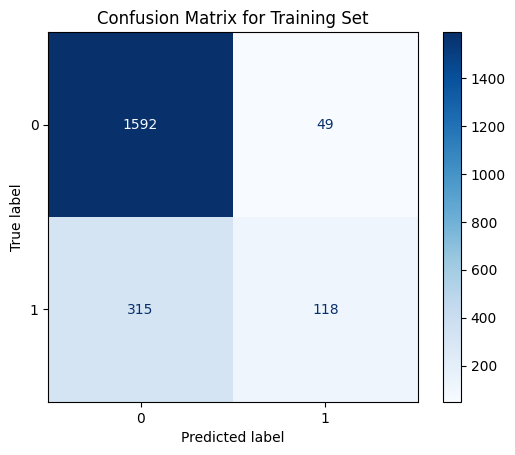

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.82      0.99      0.89       688
           1       0.84      0.26      0.39       202

    accuracy                           0.82       890
   macro avg       0.83      0.62      0.64       890
weighted avg       0.82      0.82      0.78       890



<Figure size 700x700 with 0 Axes>

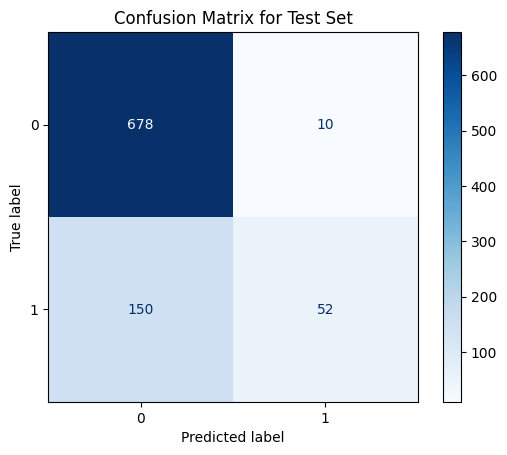

,Manual LogReg,Manual KNN,Manual SVC
train - precision,0.372599,0.777778,0.706587
train - recall,0.672055,0.598152,0.272517
train - accuracy,0.695275,0.880424,0.824494
train - f1_score,0.479407,0.676240,0.393333
test - precision,0.396285,0.585938,0.838710
test - recall,0.633663,0.371287,0.257426
test - accuracy_score,0.697753,0.797753,0.820225
test - f1_score,0.487619,0.454545,0.393939


In [ ]:
# Calculate predictions for training and test sets
y_train_pred = model_svc.predict(X_train_final)
y_test_pred = model_svc.predict(X_test_final)

# Generate classification reports for training and test sets
train_classification_report = classification_report(y_train, y_train_pred)
test_classification_report = classification_report(y_test, y_test_pred)

train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

train_conf_matrix_display = ConfusionMatrixDisplay(train_conf_matrix)
test_conf_matrix_display = ConfusionMatrixDisplay(test_conf_matrix)

print("Classification Report for Training Set:\n", train_classification_report)

# Display confusion matrix and classification report for training set
plt.figure(figsize=(7, 7))
train_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Training Set')
plt.show()


print("Classification Report for Test Set:\n", test_classification_report)

# Display confusion matrix and classification report for test set
plt.figure(figsize=(7, 7))
test_conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()

print('')

# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Manual SVC')
pd.DataFrame(all_reports)




### Cross Validate

In [ ]:
# K-fold valid
st_fold = StratifiedKFold(5)
k_fold = KFold(5)



f1_train_cross_val = cross_val_score(logReg,
                                     X_train_final,
                                     y_train,
                                     cv=st_fold,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.53941909 0.45493562 0.51383399 0.46086957 0.40769231]
F1 Score - Mean - Cross Validation :  0.4753501148918173
F1 Score - Std - Cross Validation  :  0.046453974448062846
F1 Score - Range of Test-Set       :  0.42889614044375446 - 0.5218040893398801


F1 Score - Test Set   :  0.4876190476190477 

Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.72      0.79       688
           1       0.40      0.63      0.49       202

    accuracy                           0.70       890
   macro avg       0.63      0.68      0.64       890
weighted avg       0.76      0.70      0.72       890
 

Confusion Matrix      : 


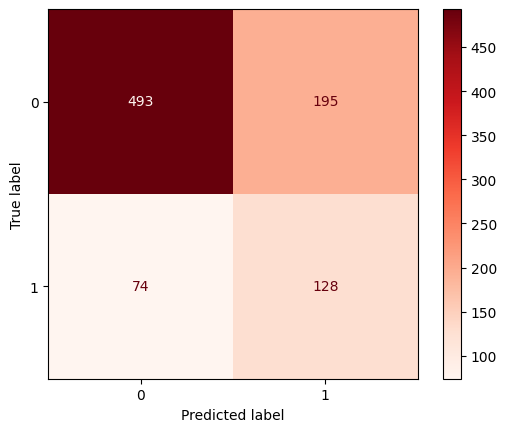

In [ ]:
# Check Performance Model against Test-Set

y_pred_test = logReg.predict(X_test_final)
# y_pred_test = model_svc.predict(X_test_final)
# y_pred_test = knn.predict(X_test_final)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(logReg, X_test_final, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'cross_val LogReg')
pd.DataFrame(all_reports)

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg
train - precision,0.372599,0.777778,0.706587,0.706587
train - recall,0.672055,0.598152,0.272517,0.272517
train - accuracy,0.695275,0.880424,0.824494,0.824494
train - f1_score,0.479407,0.676240,0.393333,0.393333
test - precision,0.396285,0.585938,0.838710,0.838710
test - recall,0.633663,0.371287,0.257426,0.257426
test - accuracy_score,0.697753,0.797753,0.820225,0.820225
test - f1_score,0.487619,0.454545,0.393939,0.393939


## Hyperparameter Tuning



#### Logistic Regression

In [ ]:
# define model
lr = LogisticRegression()
# parameter logReg
logistic_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                   'penalty': ['l1', 'l2']}

logistic_params

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

In [ ]:
# random search
lr_randomcv = RandomizedSearchCV(estimator=lr,
                                 param_distributions=logistic_params,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')
lr_randomcv.fit(X_train_final, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   random_state=46, scoring='f1')

In [ ]:
lr_randomcv.best_params_

{'penalty': 'l2', 'C': 10}

In [ ]:
# Get Best Estimator

lr_randomcv_best = lr_randomcv.best_estimator_

F1 Score - Test Set   :  0.3657587548638132 

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       688
           1       0.85      0.23      0.37       202

    accuracy                           0.82       890
   macro avg       0.83      0.61      0.63       890
weighted avg       0.82      0.82      0.77       890
 

Confusion Matrix      : 


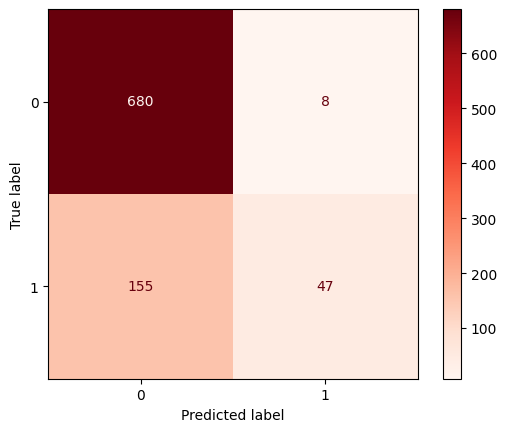

In [ ]:
# Check Performance Model against Test-Set

y_pred_test = lr_randomcv_best.predict(X_test_final)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(lr_randomcv_best, X_test_final, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Tuning LogReg')
pd.DataFrame(all_reports)

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg,Tuning LogReg
train - precision,0.372599,0.777778,0.706587,0.706587,0.706587
train - recall,0.672055,0.598152,0.272517,0.272517,0.272517
train - accuracy,0.695275,0.880424,0.824494,0.824494,0.824494
train - f1_score,0.479407,0.676240,0.393333,0.393333,0.393333
test - precision,0.396285,0.585938,0.838710,0.838710,0.838710
test - recall,0.633663,0.371287,0.257426,0.257426,0.257426
test - accuracy_score,0.697753,0.797753,0.820225,0.820225,0.820225
test - f1_score,0.487619,0.454545,0.393939,0.393939,0.393939


#### SVM Classifier

In [ ]:
# define model
svc = SVC()


# parameter svc
svc_params = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 0.01, 0.001, 0.0001],}

In [ ]:
# random search
%%time
svc_randomcv = RandomizedSearchCV(estimator=svc,
                                 param_distributions=svc_params,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')
svc_randomcv.fit(X_train_final, y_train)

CPU times: user 533 ms, sys: 25.4 ms, total: 558 ms
Wall time: 6.06 s


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [0.1, 0.01, 0.001, 0.0001]},
                   random_state=46, scoring='f1')

In [ ]:
# Get Best Hyperparameters

svc_randomcv.best_params_

{'gamma': 0.1, 'C': 100}

In [ ]:
# Get Best Estimator

svc_randomcv_best = svc_randomcv.best_estimator_

F1 Score - Test Set   :  0.44805194805194803 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.95      0.88       688
           1       0.65      0.34      0.45       202

    accuracy                           0.81       890
   macro avg       0.74      0.64      0.67       890
weighted avg       0.79      0.81      0.79       890
 

Confusion Matrix      : 


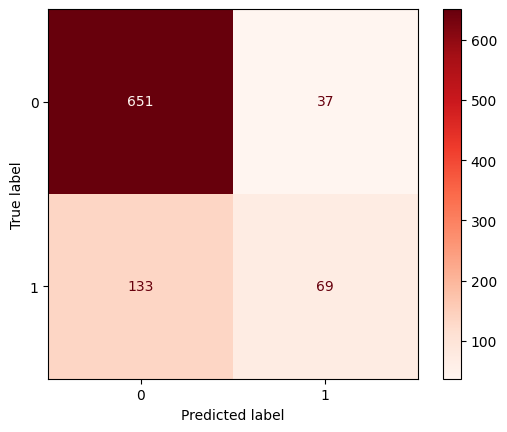

In [ ]:
# Check Performance Model against Test-Set

y_pred_test = svc_randomcv_best.predict(X_test_final)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svc_randomcv_best, X_test_final, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Tuning svc')
pd.DataFrame(all_reports)

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg,Tuning LogReg,Tuning svc
train - precision,0.372599,0.777778,0.706587,0.706587,0.706587,0.706587
train - recall,0.672055,0.598152,0.272517,0.272517,0.272517,0.272517
train - accuracy,0.695275,0.880424,0.824494,0.824494,0.824494,0.824494
train - f1_score,0.479407,0.676240,0.393333,0.393333,0.393333,0.393333
test - precision,0.396285,0.585938,0.838710,0.838710,0.838710,0.838710
test - recall,0.633663,0.371287,0.257426,0.257426,0.257426,0.257426
test - accuracy_score,0.697753,0.797753,0.820225,0.820225,0.820225,0.820225
test - f1_score,0.487619,0.454545,0.393939,0.393939,0.393939,0.393939


#### KNN

In [ ]:
# define model
kNN = KNeighborsClassifier()



knn_params = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}
knn_params

{'n_neighbors': [3, 5, 7, 9],
 'weights': ['uniform', 'distance'],
 'metric': ['euclidean', 'manhattan']}

In [ ]:
# random search
%%time
knn_randomcv = RandomizedSearchCV(estimator=kNN,
                                 param_distributions=knn_params,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='f1')
knn_randomcv.fit(X_train_final, y_train)

CPU times: user 81.6 ms, sys: 9.17 ms, total: 90.8 ms
Wall time: 1.39 s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7, 9],
                                        'weights': ['uniform', 'distance']},
                   random_state=46, scoring='f1')

In [ ]:
# Get Best Hyperparameters

knn_randomcv.best_params_

{'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}

In [ ]:
# Get Best Estimator

knn_randomcv_best = knn_randomcv.best_estimator_

F1 Score - Test Set   :  0.440251572327044 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       688
           1       0.60      0.35      0.44       202

    accuracy                           0.80       890
   macro avg       0.72      0.64      0.66       890
weighted avg       0.78      0.80      0.78       890
 

Confusion Matrix      : 


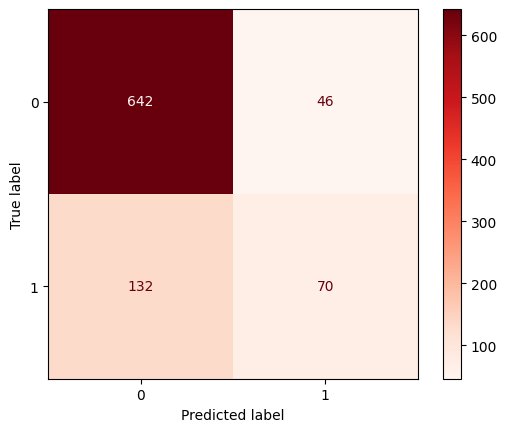

In [ ]:
# Check Performance Model against Test-Set

y_pred_test = knn_randomcv_best.predict(X_test_final)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_randomcv_best, X_test_final, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, 'Tuning knn')
pd.DataFrame(all_reports)

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg,Tuning LogReg,Tuning svc,Tuning knn
train - precision,0.372599,0.777778,0.706587,0.706587,0.706587,0.706587,0.706587
train - recall,0.672055,0.598152,0.272517,0.272517,0.272517,0.272517,0.272517
train - accuracy,0.695275,0.880424,0.824494,0.824494,0.824494,0.824494,0.824494
train - f1_score,0.479407,0.676240,0.393333,0.393333,0.393333,0.393333,0.393333
test - precision,0.396285,0.585938,0.838710,0.838710,0.838710,0.838710,0.838710
test - recall,0.633663,0.371287,0.257426,0.257426,0.257426,0.257426,0.257426
test - accuracy_score,0.697753,0.797753,0.820225,0.820225,0.820225,0.820225,0.820225
test - f1_score,0.487619,0.454545,0.393939,0.393939,0.393939,0.393939,0.393939


In [ ]:
x = pd.DataFrame(all_reports)

x.describe()

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg,Tuning LogReg,Tuning svc,Tuning knn
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.554332,0.642765,0.563404,0.563404,0.563404,0.563404,0.563404
std,0.135571,0.174928,0.258097,0.258097,0.258097,0.258097,0.258097
min,0.372599,0.371287,0.257426,0.257426,0.257426,0.257426,0.257426
25%,0.458626,0.553089,0.363129,0.363129,0.363129,0.363129,0.363129
50%,0.560641,0.637196,0.550263,0.550263,0.550263,0.550263,0.550263
75%,0.677860,0.782772,0.821292,0.821292,0.821292,0.821292,0.821292
max,0.697753,0.880424,0.838710,0.838710,0.838710,0.838710,0.838710


# x. Model Saving

In [ ]:
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(selected_num_col, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(selected_cat_col, file_2)

with open('scaler.pkl', 'wb') as file_3:
  pickle.dump(scaler, file_3)

with open('logReg.pkl', 'wb') as file_4:
  pickle.dump(logReg, file_4)

with open('model_svc.pkl', 'wb') as file_5:
  pickle.dump(model_svc, file_5)

with open('knn.pkl', 'wb') as file_6:
  pickle.dump(knn, file_6)

with open('lr_randomcv.pkl', 'wb') as file_7:
  pickle.dump(lr_randomcv, file_7)


with open('svc_randomcv.pkl', 'wb') as file_8:
  pickle.dump(svc_randomcv, file_8)

with open('knn_randomcv.pkl', 'wb') as file_9:
  pickle.dump(knn_randomcv, file_9)
  svc_randomcv



# xi. Model infernce

#### Load Model

In [ ]:
# Load model and other files

with open('list_cat_cols.txt', 'r') as file_1:
  list_cat_col = json.load(file_1)

with open('list_num_cols.txt', 'r') as file_2:
  list_num_col = json.load(file_2)

with open("knn_randomcv.pkl", "rb") as file_3:
  model = pickle.load(file_3)

with open("scaler.pkl", "rb") as file_4:
  scaler = pickle.load(file_4)



# with open("encoder.pkl", "rb") as file_5:
#   encoder = pickle.load(file_5)

#### Membuat Random Data

In [ ]:

# Generate random data
num_rows = 5  # number of rows
dataFrame = {
    'limit_balance': np.random.randint(5000, 100000, num_rows),
    'sex': np.random.choice([1, 2], num_rows),
    'education_level': np.random.choice([1, 2, 3 ,4], num_rows),
    'marital_status': np.random.choice([1,2,3,0], num_rows),
    'age': np.random.randint(18, 70, num_rows),
    'pay_0': np.random.randint(-2, 8, num_rows),
    'pay_2': np.random.randint(-2, 8, num_rows),
    'pay_3': np.random.randint(-2, 8, num_rows),
    'pay_4': np.random.randint(-2, 8, num_rows),
    'pay_5': np.random.randint(-2, 8, num_rows),
    'pay_6': np.random.randint(-2, 8, num_rows),
    'bill_amt_1': np.random.randint(0, 100000, num_rows),
    'bill_amt_2': np.random.randint(0, 100000, num_rows),
    'bill_amt_3': np.random.randint(0, 100000, num_rows),
    'bill_amt_4': np.random.randint(0, 100000, num_rows),
    'bill_amt_5': np.random.randint(0, 100000, num_rows),
    'bill_amt_6': np.random.randint(0, 100000, num_rows),
    'pay_amt_1': np.random.randint(0, 30000, num_rows),
    'pay_amt_2': np.random.randint(0, 30000, num_rows),
    'pay_amt_3': np.random.randint(0, 30000, num_rows),
    'pay_amt_4': np.random.randint(0, 30000, num_rows),
    'pay_amt_5': np.random.randint(0, 30000, num_rows),
    'pay_amt_6': np.random.randint(0, 30000, num_rows),
    'default_payment_next_month': np.random.choice([0, 1], num_rows)
}

# Create DataFrame
random_data = pd.DataFrame(dataFrame)

# Display the first few rows of the DataFrame
random_data.head().T

,0,1,2,3,4
limit_balance,49706,86238,66990,18543,50878
sex,2,1,2,1,2
education_level,3,1,3,4,2
marital_status,1,2,1,2,0
age,33,31,51,31,43
pay_0,5,3,2,7,3
pay_2,0,-2,-2,-1,-2
pay_3,2,7,0,-2,6
pay_4,6,2,3,-1,7
pay_5,4,5,1,0,1


### Splitting

In [ ]:
#Splitting the dataset into categorical and numerical columns

data_inference_num = random_data[list_num_col]
data_inference_cat = random_data[list_cat_col]

In [ ]:
data_inference_num

,limit_balance,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,49706,12451,7726,14350,27760,1434,20827
1,86238,20506,7266,14864,27094,14986,28460
2,66990,28430,23606,10246,16679,11438,24116
3,18543,4327,20279,28474,4791,18378,23137
4,50878,13923,10110,9280,3840,3322,16803


In [ ]:
data_inference_cat

,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,3,5,0,2,6,4,-1
1,1,3,-2,7,2,5,2
2,3,2,-2,0,3,1,-2
3,4,7,-1,-2,-1,0,6
4,2,3,-2,6,7,1,0


#### Scaling

In [ ]:
data_inference_num_scaled = scaler.fit_transform(data_inference_num,data_inference_cat)
data_inference_num_scaled

array([[0.46034419, 0.33705348, 0.02815177, 0.26414505, 1.        ,
        0.        , 0.34520031],
       [1.        , 0.67124424, 0.        , 0.29092425, 0.97215719,
        0.79981114, 1.        ],
       [0.71566585, 1.        , 1.        , 0.05032823, 0.53674749,
        0.59041549, 0.62734837],
       [0.        , 0.        , 0.79638923, 1.        , 0.03975753,
        1.        , 0.5433645 ],
       [0.47765714, 0.39812471, 0.17405141, 0.        , 0.        ,
        0.11142587, 0.        ]])

#### Concatenate

In [ ]:
data_inference_final = np.concatenate([data_inference_num_scaled, data_inference_cat], axis = 1)
data_inference_final

array([[ 0.46034419,  0.33705348,  0.02815177,  0.26414505,  1.        ,
         0.        ,  0.34520031,  3.        ,  5.        ,  0.        ,
         2.        ,  6.        ,  4.        , -1.        ],
       [ 1.        ,  0.67124424,  0.        ,  0.29092425,  0.97215719,
         0.79981114,  1.        ,  1.        ,  3.        , -2.        ,
         7.        ,  2.        ,  5.        ,  2.        ],
       [ 0.71566585,  1.        ,  1.        ,  0.05032823,  0.53674749,
         0.59041549,  0.62734837,  3.        ,  2.        , -2.        ,
         0.        ,  3.        ,  1.        , -2.        ],
       [ 0.        ,  0.        ,  0.79638923,  1.        ,  0.03975753,
         1.        ,  0.5433645 ,  4.        ,  7.        , -1.        ,
        -2.        , -1.        ,  0.        ,  6.        ],
       [ 0.47765714,  0.39812471,  0.17405141,  0.        ,  0.        ,
         0.11142587,  0.        ,  2.        ,  3.        , -2.        ,
         6.        ,  7.  

#### Predicting

In [ ]:
y_pred_inference = model.predict(data_inference_final)
y_pred_inference

array([1, 1, 1, 0, 1])

# xii. Kesimpulan

In [ ]:
x

,Manual LogReg,Manual KNN,Manual SVC,cross_val LogReg,Tuning LogReg,Tuning svc,Tuning knn
train - precision,0.372599,0.777778,0.706587,0.706587,0.706587,0.706587,0.706587
train - recall,0.672055,0.598152,0.272517,0.272517,0.272517,0.272517,0.272517
train - accuracy,0.695275,0.880424,0.824494,0.824494,0.824494,0.824494,0.824494
train - f1_score,0.479407,0.676240,0.393333,0.393333,0.393333,0.393333,0.393333
test - precision,0.396285,0.585938,0.838710,0.838710,0.838710,0.838710,0.838710
test - recall,0.633663,0.371287,0.257426,0.257426,0.257426,0.257426,0.257426
test - accuracy_score,0.697753,0.797753,0.820225,0.820225,0.820225,0.820225,0.820225
test - f1_score,0.487619,0.454545,0.393939,0.393939,0.393939,0.393939,0.393939


Dari Semua Model yang saya buat `KNN model` lebih baik dari yang lain. Pada dasarnya dataset untuk predict `default_payment_next_month` memiliki proporsi class 0 lebih banyak dari 1 sehingga data disebut `Imbalance`.

saya sudah melakukan tuning parameter namun hasil tidak berbeda jauh, berikut best parameter:


`Logistic Regression = {'penalty': 'l2', 'C': 10}`

`SVM classifier = {'gamma': 0.1, 'C': 100}`

`K-Nearst Neighbors = {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}`

Kesimpulan domain knowladge adalah Customer cederung tidak akan bayar bualan depan yang mana dilihat dari data history yang mana memiliki pola tertentu.


